# Geopandas recipes for feature data

Geoprocessing is all about solving particular problems. Most can be tackled combining a few basic techniques. This notebook provides a cookbook for some of the most useful ones.

various sources

<!--TABLE OF CONTENTS-->
Contents:
- [Creating a geodataframe from point lat-lon features](#Creating-a-geodataframe-from-point-lat-lon-features)
- [Create a regular grid of polygons](#Create-a-regular-grid-of-polygons)
- [Clipping polygons using other polygons](#Clipping-polygons-using-other-polygons)
- [Intersection](#Intersection)
- [Union](#Union)
- [Buffer](#Buffer)
- [Merging data](#Merging-data)
  - [Append](#Append)
    - [appending a GeoSeries](#appending-a-GeoSeries)
    - [appending a GeoDataFrame](#appending-a-GeoDataFrame)
  - [attribute joins](#attribute-joins)
  - [spatial joins](#spatial-joins)
- [Dissolve](#Dissolve)
- [Getting points from lines / polygons](#Getting-points-from-lines-/-polygons)
  - [Polygons](#Polygons)
    - [centroids and representative points](#centroids-and-representative-points)
    - [getting points from the exterior](#getting-points-from-the-exterior)
  - [lines](#lines)
- [Nearest points](#Nearest-points)

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from shapely.ops import nearest_points
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

# Creating a geodataframe from point lat-lon features
This example is taken from the geopandas documentation here: https://geopandas.org/gallery/create_geopandas_from_pandas.html

In [2]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

In [3]:
df

,City,Country,Latitude,Longitude
0,Buenos Aires,Argentina,-34.58,-58.66
1,Brasilia,Brazil,-15.78,-47.91
2,Santiago,Chile,-33.45,-70.66
3,Bogota,Colombia,4.60,-74.08
4,Caracas,Venezuela,10.48,-66.86


In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [5]:
gdf

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot:>

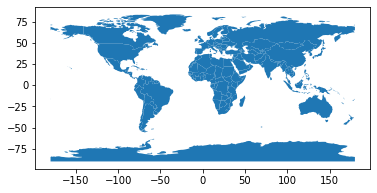

In [7]:
world.plot()

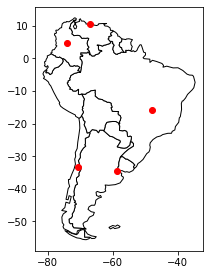

In [8]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
world[world.continent == 'South America'].plot(
    color='white', edgecolor='black', ax=ax)
gdf.plot(ax=ax, color='red')
plt.show()

# Create a regular grid of polygons
Example adapted from here: https://gis.stackexchange.com/questions/269243/creating-polygon-grid-using-geopandas

In [9]:
xmin, ymin, xmax, ymax = -180, -90, 180, 90
length = 10
width = 10
cols = np.arange(xmin, xmax, width)
rows = np.arange(ymin, ymax, length)

In [10]:
polygons = [Polygon([(x,y), 
                     (x+width, y),
                     (x+width, y+length),
                     (x, y+length)]) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry':polygons})

In [11]:
grid = grid.set_crs(epsg=4326)

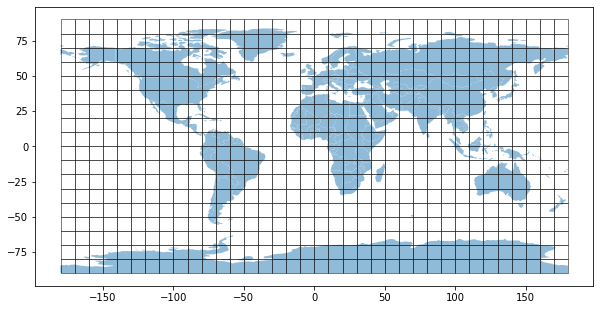

In [12]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
world.plot(ax=ax)
grid.plot(color='white', edgecolor='black', ax=ax, alpha=0.5)
plt.show()

# Clipping polygons using other polygons

In [13]:
sa = world[world.continent == 'South America']
sa_grid = gpd.clip(grid, sa)

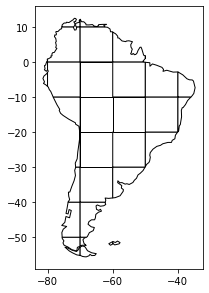

In [14]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
sa_grid.plot(color='white', edgecolor='black', ax=ax)
plt.show()

# Intersection

Note that `overlay` is only for geometries of the same type. See the documentation:

https://geopandas.org/reference/geopandas.overlay.html

In [15]:
sa = world[world.continent == 'South America']
sa_grid_int = gpd.overlay(grid, sa, how='intersection')

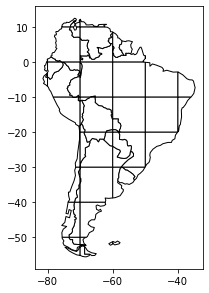

In [16]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
sa_grid_int.plot(color='white', edgecolor='black', ax=ax)
plt.show()

to make this and the following examples a little more visual, we will use two standard shapes

In [17]:
square = gpd.GeoDataFrame({'geometry': Polygon([(0, 0),
                                                (1, 0),
                                                (1, 1),
                                                (0, 1)])},
                         index=[0]).set_crs(epsg=4326)
center = pd.DataFrame({'lat': [1], 'lon': [0.5]})
centroid = gpd.GeoDataFrame(center,
                            geometry=gpd.points_from_xy(center.lon,
                                                        center.lat))
circle = gpd.GeoDataFrame({'geometry': centroid.buffer(0.4)}).set_crs(epsg=4326)

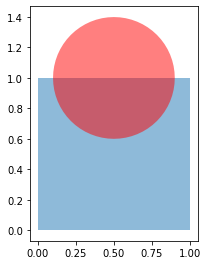

In [18]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
square.plot(ax=ax, alpha=0.5)
circle.plot(ax=ax, alpha=0.5, color='r')
plt.show()

<AxesSubplot:>

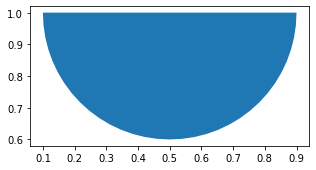

In [19]:
circ_sqr_intersection = gpd.overlay(square, circle, how='intersection')
circ_sqr_intersection.plot(figsize=(5,3))

# Union

<AxesSubplot:>

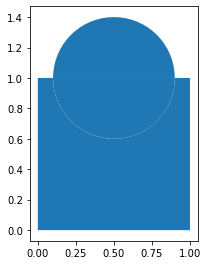

In [20]:
circ_sqr_union = gpd.overlay(square, circle, how='union')
circ_sqr_union.plot(figsize=(3, 5))

Note the other options for `overlay()` currently implemented: `identity`, `symmetric_difference` or `difference`.

# Buffer
We have already used this above to make the `circle`. Let's see a few more examples

In [21]:
center = pd.DataFrame({'lat': [1], 'lon': [0.5]})
centroid = gpd.GeoDataFrame(center,
                            geometry=gpd.points_from_xy(center.lon,
                                                        center.lat))
buffer_point = gpd.GeoDataFrame({'geometry': centroid.buffer(0.4)}).set_crs(epsg=4326)
centroid = centroid.set_crs(epsg=4236)

In [22]:
rivers = gpd.read_file('./data/ne_110m_rivers_lake_centerlines/ne_110m_rivers_lake_centerlines.shp')
amazon = rivers[rivers.name == 'Amazonas']
buffer_line = amazon.buffer(0.5)

<ipython-input-22-f696a3b065f5>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_line = amazon.buffer(0.5)


In [23]:
buffer_polygon = square.buffer(0.5)

<ipython-input-23-9170f7d45f22>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer_polygon = square.buffer(0.5)


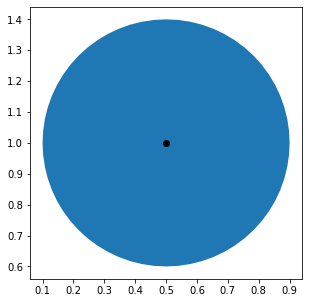

In [24]:
f, ax = plt.subplots(1,1, figsize = (5, 5))
buffer_point.plot(ax=ax)
centroid.plot(ax=ax, color='k')
plt.show()

<AxesSubplot:>

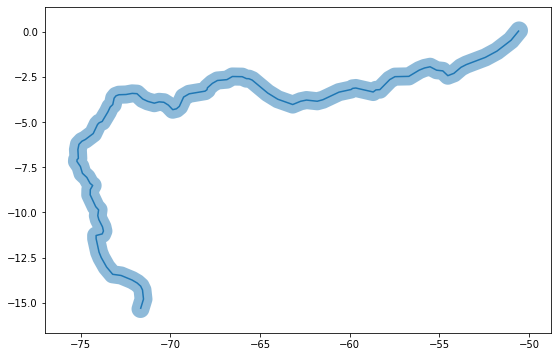

In [25]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
amazon.plot(ax=ax)
buffer_line.plot(ax=ax, alpha=0.5)

<AxesSubplot:>

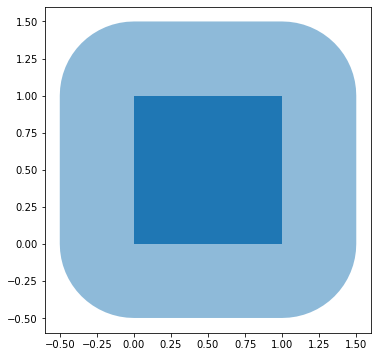

In [26]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
square.plot(ax=ax)
buffer_polygon.plot(ax=ax, alpha=0.5)

# Merging data

The following three examples are from here: https://geopandas.org/docs/user_guide/mergingdata.html

In [27]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

For the attribute join

In [28]:
# For attribute join
country_shapes = world[['geometry', 'iso_a3']]
country_names = world[['name', 'iso_a3']]

In [29]:
# For spatial join
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'})

## Append

### appending a GeoSeries

In [30]:
joined = world.geometry.append(cities.geometry)

<AxesSubplot:>

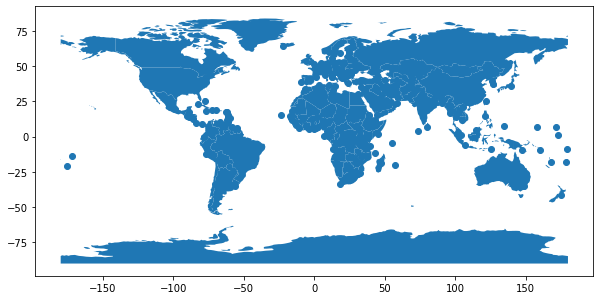

In [31]:
joined.plot(figsize=(10, 6))

### appending a GeoDataFrame

In [32]:
europe = world[(world.continent == 'Europe') & (world['name'] != 'Russia')]
africa = world[world.continent == 'Africa']
eurafrica = europe.append(africa)

<AxesSubplot:>

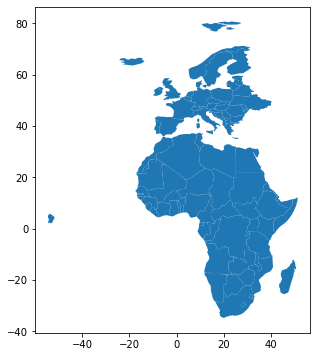

In [33]:
eurafrica.plot(figsize=(10, 6))

## attribute joins

In [34]:
country_shapes.head()

,geometry,iso_a3
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA


In [35]:
country_names.head()

,name,iso_a3
0,Fiji,FJI
1,Tanzania,TZA
2,W. Sahara,ESH
3,Canada,CAN
4,United States of America,USA


In [36]:
country_shapes_names = country_shapes.merge(country_names, on='iso_a3')

In [37]:
country_shapes_names.head()

,geometry,iso_a3,name
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,Fiji
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,Tanzania
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH,W. Sahara
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,Canada
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,United States of America


In [38]:
country_names_cheaut = country_names[country_names.iso_a3.isin(['CHE', 'AUT'])]
country_shapes_names_cheaut = country_shapes.merge(country_names_cheaut, on='iso_a3', how='inner')

<AxesSubplot:>

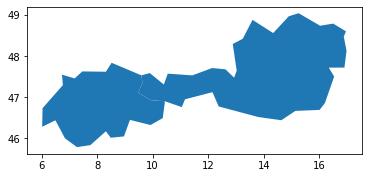

In [39]:
country_shapes_names_cheaut.plot()

In [40]:
country_shapes_names_cheaut = country_shapes.merge(country_names_cheaut, on='iso_a3', how='outer')

<AxesSubplot:>

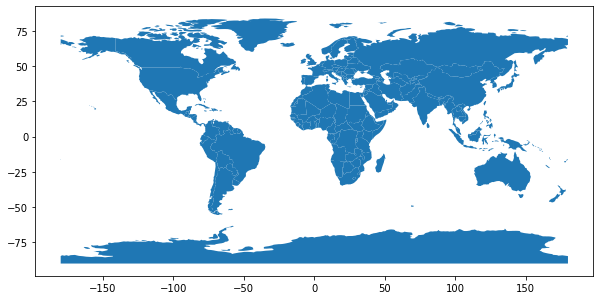

In [41]:
country_shapes_names_cheaut.plot(figsize=(10, 6))

In [42]:
country_shapes_names_cheaut.head()

,geometry,iso_a3,name
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,NaN
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,NaN
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",ESH,NaN
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,NaN
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,NaN


## spatial joins

In [43]:
countries.head()

,geometry,country
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",W. Sahara
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America


In [44]:
cities.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


<AxesSubplot:>

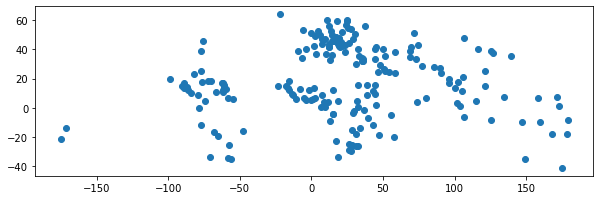

In [45]:
cities.plot(figsize=(10, 6))

In [46]:
cities_with_country = gpd.sjoin(cities, countries, how="inner", op='intersects')

<AxesSubplot:>

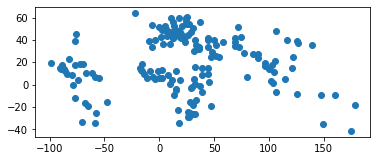

In [47]:
cities_with_country.plot()

In [48]:
cities_with_country.head()

,name,geometry,index_right,country
0,Vatican City,POINT (12.45339 41.90328),141,Italy
1,San Marino,POINT (12.44177 43.93610),141,Italy
192,Rome,POINT (12.48131 41.89790),141,Italy
2,Vaduz,POINT (9.51667 47.13372),114,Austria
184,Vienna,POINT (16.36469 48.20196),114,Austria


Note that `sjoin` supports different types of joins based on spatial relationships:

- `intersects`
- `contains`
- `within`
- `touches`
- `crosses`
- `overlaps`

For more, see the `geopandas` documentation:

https://geopandas.org/docs/user_guide/mergingdata.html

# Dissolve

this is taken from here https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html

In [49]:
continents = world.dissolve(by='continent')

<AxesSubplot:>

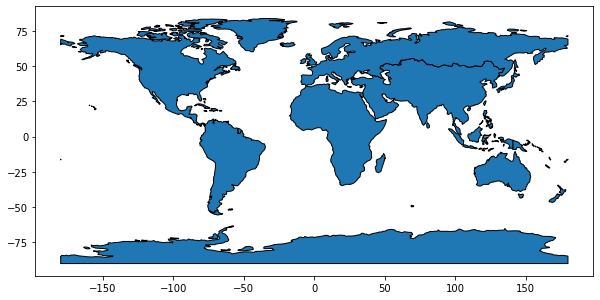

In [50]:
continents.plot(figsize=(10, 6), edgecolor='black')

In [51]:
continents

,geometry,pop_est,name,iso_a3,gdp_md_est
continent,,,,,
Africa,"MULTIPOLYGON (((40.437 -11.762, 40.561 -12.639...",53950935,Tanzania,TZA,150600.0
Antarctica,"MULTIPOLYGON (((-61.139 -79.981, -60.610 -79.6...",4050,Antarctica,ATA,810.0
Asia,"MULTIPOLYGON (((120.295 -10.259, 118.968 -9.55...",18556698,Kazakhstan,KAZ,460700.0
Europe,"MULTIPOLYGON (((-53.779 2.377, -54.088 2.106, ...",142257519,Russia,RUS,3745000.0
North America,"MULTIPOLYGON (((-78.215 7.512, -78.429 8.052, ...",35623680,Canada,CAN,1674000.0
Oceania,"MULTIPOLYGON (((171.949 -41.514, 172.097 -40.9...",920938,Fiji,FJI,8374.0
Seven seas (open ocean),"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...",140,Fr. S. Antarctic Lands,ATF,16.0
South America,"MULTIPOLYGON (((-57.750 -51.550, -58.050 -51.9...",44293293,Argentina,ARG,879400.0


Note that you can use `dissolve` to compute statistics. For example

In [52]:
continents = world.dissolve(by='continent', aggfunc='sum')

In [53]:
continents

,geometry,pop_est,gdp_md_est
continent,,,
Africa,"MULTIPOLYGON (((40.437 -11.762, 40.561 -12.639...",1219176238,6025295.50
Antarctica,"MULTIPOLYGON (((-61.139 -79.981, -60.610 -79.6...",4050,810.00
Asia,"MULTIPOLYGON (((120.295 -10.259, 118.968 -9.55...",4389144868,55434607.77
Europe,"MULTIPOLYGON (((-53.779 2.377, -54.088 2.106, ...",746398461,25284877.00
North America,"MULTIPOLYGON (((-78.215 7.512, -78.429 8.052, ...",573042112,23505137.00
Oceania,"MULTIPOLYGON (((171.949 -41.514, 172.097 -40.9...",36782844,1412885.00
Seven seas (open ocean),"POLYGON ((68.935 -48.625, 69.580 -48.940, 70.5...",140,16.00
South America,"MULTIPOLYGON (((-57.750 -51.550, -58.050 -51.9...",418540749,6377091.80


Different aggregation functions are possible. See the documentation.

# Getting points from lines / polygons

## Polygons

In [54]:
non_convex = gpd.GeoDataFrame({'geometry': Polygon([(0,0), (2,2), (0, 4), (3, 2)])}, index=[0])
non_convex = non_convex.set_crs(epsg=4326)

### centroids and representative points

In [55]:
centroid = gpd.GeoDataFrame({'geometry': non_convex.centroid}).set_crs(epsg=4326)
rep_point = gpd.GeoDataFrame({'geometry': non_convex.representative_point()}).set_crs(epsg=4326)

<ipython-input-55-bbd3511367fa>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gpd.GeoDataFrame({'geometry': non_convex.centroid}).set_crs(epsg=4326)


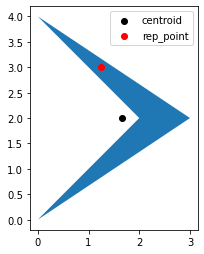

In [56]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
non_convex.plot(ax=ax)
centroid.plot(ax=ax, color='k', label='centroid')
rep_point.plot(ax=ax, color='r', label='rep_point')
ax.legend()

### getting points from the exterior

The following two are taken from here:

https://gis.stackexchange.com/questions/302430/polygon-to-point-in-geopandas

In [57]:
edgepoints_multi = non_convex.copy()
edgepoints_multi.geometry = edgepoints_multi.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
edgepoints_multi

,geometry
0,"MULTIPOINT (0.00000 0.00000, 2.00000 2.00000, ..."


<AxesSubplot:>

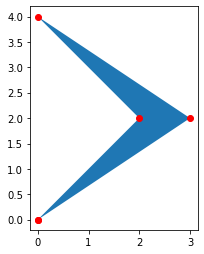

In [58]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
non_convex.plot(ax=ax)
edgepoints_multi.plot(ax=ax, color='r')

In [59]:
nodes = gpd.GeoDataFrame(columns=['geometry'])

In [60]:
for index, row in non_convex.iterrows():
    for j in list(row['geometry'].exterior.coords): 
        nodes = nodes.append({'geometry':Point(j) },ignore_index=True)

In [61]:
nodes

,geometry
0,POINT (0.00000 0.00000)
1,POINT (2.00000 2.00000)
2,POINT (0.00000 4.00000)
3,POINT (3.00000 2.00000)
4,POINT (0.00000 0.00000)


<AxesSubplot:>

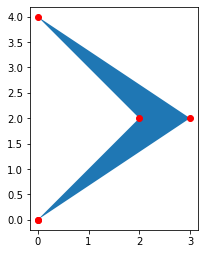

In [62]:
f, ax = plt.subplots(1,1, figsize=(3, 5))
non_convex.plot(ax=ax)
nodes.plot(ax=ax, color='r')

## lines

same principle

In [63]:
nodes = gpd.GeoDataFrame(columns=['geometry'])
for index, row in amazon.iterrows():
    for j in list(row['geometry'].coords): 
        nodes = nodes.append({'geometry':Point(j)},ignore_index=True)

In [64]:
nodes

,geometry
0,POINT (-71.66875 -15.33638)
1,POINT (-71.50116 -14.79233)
2,POINT (-71.55754 -14.28688)
3,POINT (-71.65921 -14.07795)
4,POINT (-71.85713 -13.90168)
...,...
94,POINT (-53.49644 -1.82811)
95,POINT (-52.43620 -1.43077)
96,POINT (-51.78818 -1.08510)
97,POINT (-51.00024 -0.48317)


<AxesSubplot:>

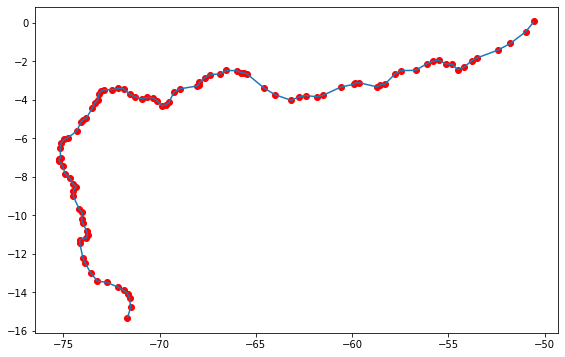

In [65]:
f, ax = plt.subplots(1,1, figsize=(10, 6))
amazon.plot(ax=ax)
nodes.plot(ax=ax, color='r')

# Nearest points

The crucial ingredient is the method `nearest_points` from `shapely`. But before we can use it, we have do do some gymnastics. 

In [66]:
aeaa_crs = CRS.from_string("esri:102022")
africa_aeaa = africa.to_crs(aeaa_crs)
africa_aeaa.crs

<Projected CRS: ESRI:102022>
Name: Africa_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Africa
- bounds: (-25.0, -35.0, 55.0, 39.0)
Coordinate Operation:
- name: Africa_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [67]:
africa_aeaa = africa_aeaa.sort_values(by='name').reset_index(drop=True)

In [68]:
centroids_africa = gpd.GeoDataFrame({'geometry': africa_aeaa.centroid})
centroids_africa['country'] = africa_aeaa.name

<AxesSubplot:>

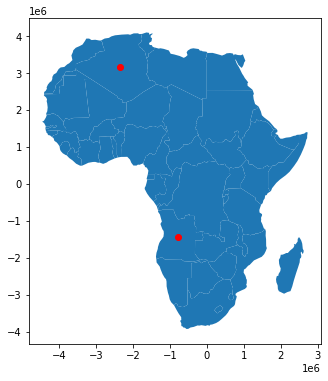

In [69]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
africa_aeaa.plot(ax = ax)
centroids_africa.iloc[0:2,:].plot(ax=ax, color='r')

In [70]:
africa_diss = africa.dissolve(by='continent').geometry

In [71]:
africa_diss

continent
Africa    MULTIPOLYGON (((40.43725 -11.76171, 40.56081 -...
Name: geometry, dtype: geometry

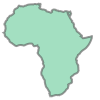

In [72]:
africa_diss.geometry.values[0][0]

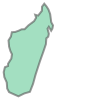

In [73]:
africa_diss.geometry.values[0][1]

In [74]:
africa_diss = gpd.GeoDataFrame({'geometry': africa_diss.geometry.values[0]})

In [75]:
africa_diss

,geometry
0,"POLYGON ((40.43725 -11.76171, 40.56081 -12.639..."
1,"POLYGON ((50.20027 -16.00026, 49.86061 -15.414..."


In [76]:
africa_coast = gpd.GeoDataFrame({'geometry': africa_diss.geometry.exterior})

In [77]:
africa_coast

,geometry
0,"LINEARRING (40.43725 -11.76171, 40.56081 -12.6..."
1,"LINEARRING (50.20027 -16.00026, 49.86061 -15.4..."


In [78]:
africa_coast = gpd.GeoDataFrame({'geometry': [MultiLineString([africa_coast.geometry[0],
                                                              africa_coast.geometry[1]])]})

<AxesSubplot:>

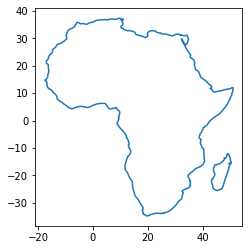

In [79]:
africa_coast.plot()

In [80]:
africa_coast

,geometry
0,"MULTILINESTRING ((40.43725 -11.76171, 40.56081..."


In [81]:
africa_coast = africa_coast.set_crs(epsg=4326)

In [82]:
africa_coast = africa_coast.to_crs(aeaa_crs)
africa_coast

,geometry
0,"MULTILINESTRING ((1591089.263 -1396295.832, 16..."


Now we can apply `nearest_points`

In [83]:
centroids_africa['coast_coords'] = centroids_africa.apply(lambda x: nearest_points(africa_coast.geometry[0],
                                                                                   x['geometry'])[0], axis=1)
coast_points_africa = gpd.GeoDataFrame(centroids_africa[['country', 'coast_coords']])
coast_points_africa['geometry'] = coast_points_africa['coast_coords']

In [84]:
connector_lines = centroids_africa.copy()
connector_lines['geometry'] = connector_lines.apply(lambda x: LineString([x['geometry'], x['coast_coords']]), axis=1)

and now for the big payoff...

<AxesSubplot:>

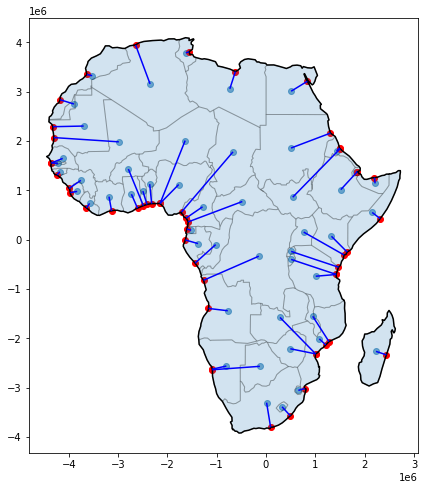

In [85]:
f, ax = plt.subplots(1,1, figsize=(12, 8))
centroids_africa.plot(ax=ax, alpha=0.6)
africa_coast.plot(ax=ax, color='k')
coast_points_africa.plot(ax=ax, color='r')
connector_lines.plot(ax=ax, color='b')
africa_aeaa.plot(ax=ax, alpha=0.2, edgecolor='k')

Phew!